# Compare Modtran/libRadTran transmissions : Study O2

- author : Sylvie Dagoret
- affiliation : LAL/IN2P3/CNRS
- creation date : July 11th 2018



In [85]:
import pandas as pd
import numpy as np
import os,sys
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
from scipy.interpolate import interp1d

In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [88]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [89]:
import matplotlib
matplotlib.rc_file("templates/matplotlibrc")

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [90]:
PATH_LIBRADTRAN='./librandtran'
PATH_MODTRAN='./modtran'

In [91]:
sys.path.append(PATH_LIBRADTRAN)
sys.path.append(PATH_MODTRAN)

In [92]:
import libReadModtran as mt
import libsimulateTranspLSSTScattAbsAer3 as rt
import libsimulateTranspLSSTScattAbsAer3_lowtran as lt

# Config

In [93]:
#------------------------------------------------------------------------
# Definition of data format for the atmospheric grid
#-----------------------------------------------------------------------------
WLMIN=250.  # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=1100. # Minimum wavelength : PySynPhot works with Angstrom
WL=np.arange(WLMIN,WLMAX,1) # Array of wavelength in Angstrom
NBWL=len(WL)


## Config for Modtran

In [94]:
path_modtrandata='modtrandata/Jul6th2018'

In [95]:
def GetModtranFilenames():
    files_data = [f for f in listdir(path_modtrandata) if isfile(join(path_modtrandata, f))]
    files_data.sort()
    
    # select reduced files
    files_selected=[]
    for file in files_data:
        if file.find("_reduced")==-1:
            print("reject ",file)
        else:
            files_selected.append(file)
            
    files_selected.sort()
    return files_selected


In [96]:
def GetAirmassFromModtranFilename(filename):
    splitted_filename=filename.split('.')
    tagname=splitted_filename[1]
    airmass_str=tagname.split('_')[0]
    am=float(airmass_str)/10.
    return am
    

In [97]:
files_modtran=GetModtranFilenames()

reject  Pachon_MODTRAN.10.7sc
reject  Pachon_MODTRAN.11.7sc
reject  Pachon_MODTRAN.12.7sc
reject  Pachon_MODTRAN.13.7sc
reject  Pachon_MODTRAN.14.7sc
reject  Pachon_MODTRAN.15.txt
reject  Pachon_MODTRAN.16.7sc
reject  Pachon_MODTRAN.17.7sc
reject  Pachon_MODTRAN.18.7sc
reject  Pachon_MODTRAN.19.7sc
reject  Pachon_MODTRAN.20.7sc
reject  Pachon_MODTRAN.21.7sc
reject  Pachon_MODTRAN.22.7sc
reject  Pachon_MODTRAN.23.7sc
reject  Pachon_MODTRAN.25.7sc
reject  Pachon_MODTRAN.7sc


In [98]:
NBFILES=len(files_modtran)-1

### Get all all available Modtran Airmasss

In [99]:
all_airmasses=[GetAirmassFromModtranFilename(files_modtran[idx]) for idx in np.arange(NBFILES) ]

### Read all Modtran Data

In [100]:
all_mtdata=[]
for file in files_modtran:
    fullfilename=os.path.join(path_modtrandata,file)
    read_modtrandata=mt.loadtape7(fullfilename, colspec = ['WAVELENGTH_NM','COMBIN_TRANS'])
    all_mtdata.append(read_modtrandata)

### View all Modtran Data

In [101]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

(600.0, 800.0)

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


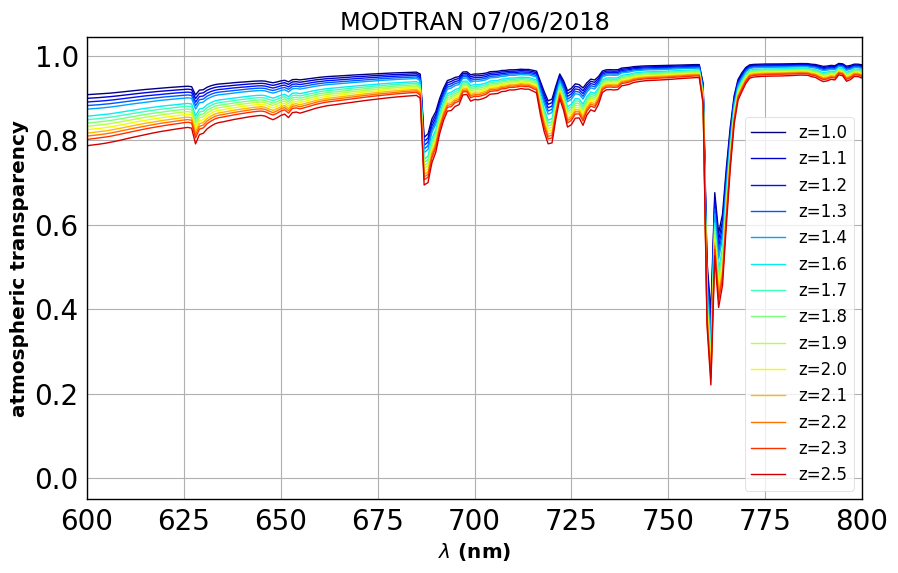

In [102]:
fig = plt.figure(figsize=(10,6))                                                               
ax = fig.add_subplot(1,1,1)  
for idx in np.arange(NBFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="z={:2.1f}".format(all_airmasses[idx])
    ax.plot(all_mtdata[idx][:,0],all_mtdata[idx][:,1],color=colorVal,label=thelabel)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
ax.grid(True)
ax.set_title("MODTRAN 07/06/2018")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("atmospheric transparency")
ax.legend(loc='best')
ax.set_xlim(600.,800.)

In [103]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

# Simulate LibRadTran

In [104]:
am=1
pressure = 782.5
pwv=4.95
aer=0
ozone=350.
wl0=500.

In [105]:
all_rtdata=[]
for am in all_airmasses:
    path,thefile=rt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
    #path,thefile=ProcessSimulation(am,pwv,ozone)
    data = np.loadtxt(os.path.join(path,thefile))
    all_rtdata.append(data)

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.95
 3) oz =  350.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv49_oz35_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv49_oz35_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv49_oz35_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv49_oz35_aer0.OUT
--------------------------------------------
 1) airmass =  1.1
 2) pwv =  4.95
 3) oz =  350.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa

In [106]:
all_ltdata=[]
for am in all_airmasses:
    path,thefile=lt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
    #path,thefile=ProcessSimulation(am,pwv,ozone)
    data = np.loadtxt(os.path.join(path,thefile))
    all_ltdata.append(data)

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.95
 3) oz =  350.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/lt/in/RT_LS_pp_us_sa_lt_z10_wv49_oz35_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/lt/out/RT_LS_pp_us_sa_lt_z10_wv49_oz35_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/lt/in/RT_LS_pp_us_sa_lt_z10_wv49_oz35_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/lt/out/RT_LS_pp_us_sa_lt_z10_wv49_oz35_aer0.OUT
--------------------------------------------
 1) airmass =  1.1
 2) pwv =  4.95
 3) oz =  350.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/lt/in/RT_LS_pp_us_sa

# Work with One  airmass

In [107]:
index_sel_airmass=2
sel_airmass=all_airmasses[index_sel_airmass]

(0.2, 1.0)

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


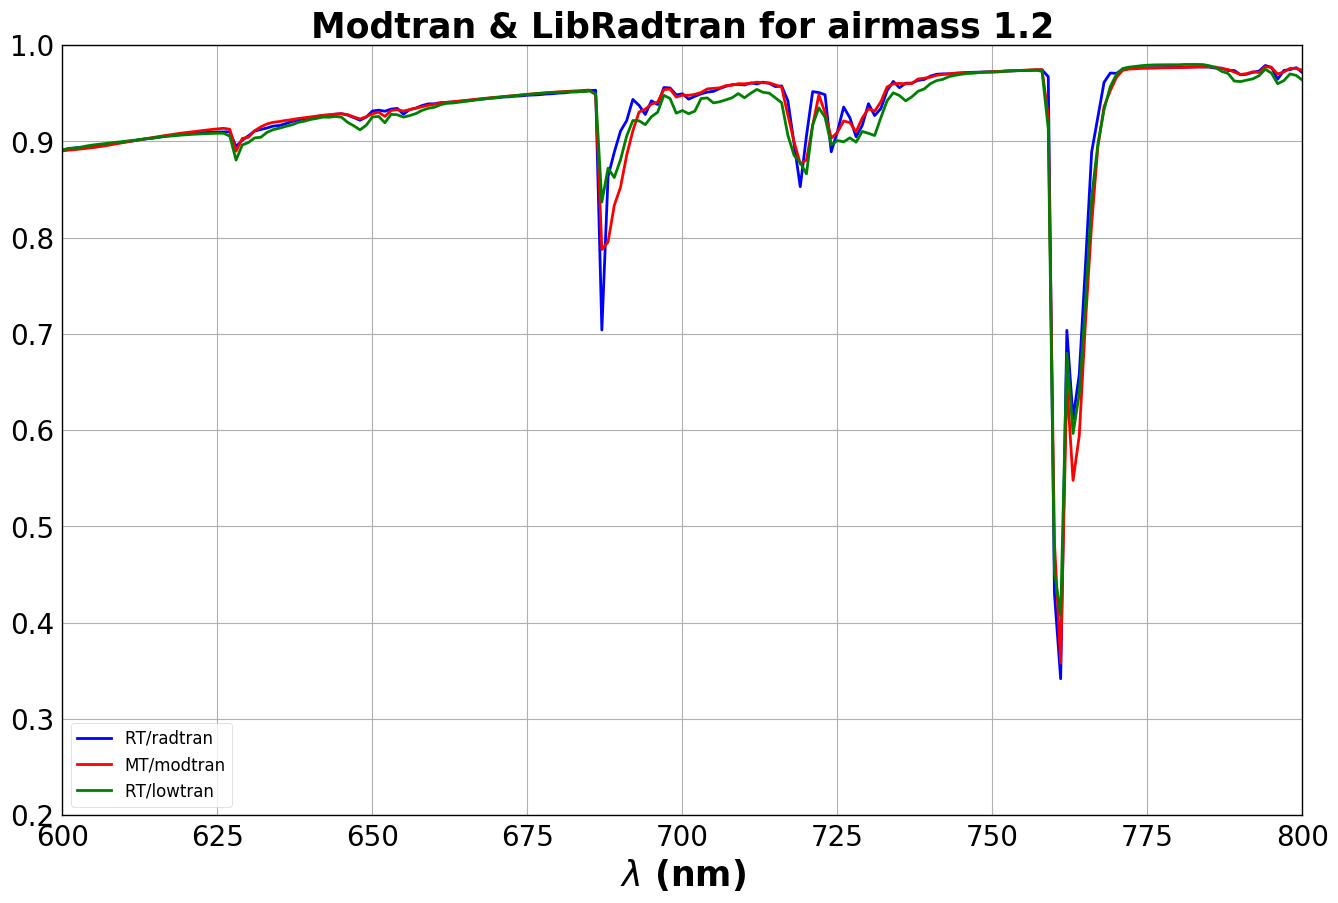

In [108]:
fig = plt.figure(figsize=(16,10))     
#fig = plt.figure(figsize=(18,12))    
ax = fig.add_subplot(1,1,1)  
ax.plot(all_rtdata[index_sel_airmass][:,0],all_rtdata[index_sel_airmass][:,1],"b-",lw=2,label="RT/radtran")
ax.plot(all_mtdata[index_sel_airmass][:,0],all_mtdata[index_sel_airmass][:,1],"r-",lw=2,label="MT/modtran")
ax.plot(all_ltdata[index_sel_airmass][:,0],all_ltdata[index_sel_airmass][:,1],"g-",lw=2,label="RT/lowtran")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
title='Modtran & LibRadtran for airmass {:2.1f}'.format(sel_airmass)
ax.grid(True)
ax.legend()
ax.set_title(title,fontsize=25,fontweight='bold')
ax.set_xlabel("$\lambda$ (nm)",fontsize=25,fontweight='bold')
ax.set_xlim(600.,800.)
ax.set_ylim(0.2,1.)

(0.2, 1.0)

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


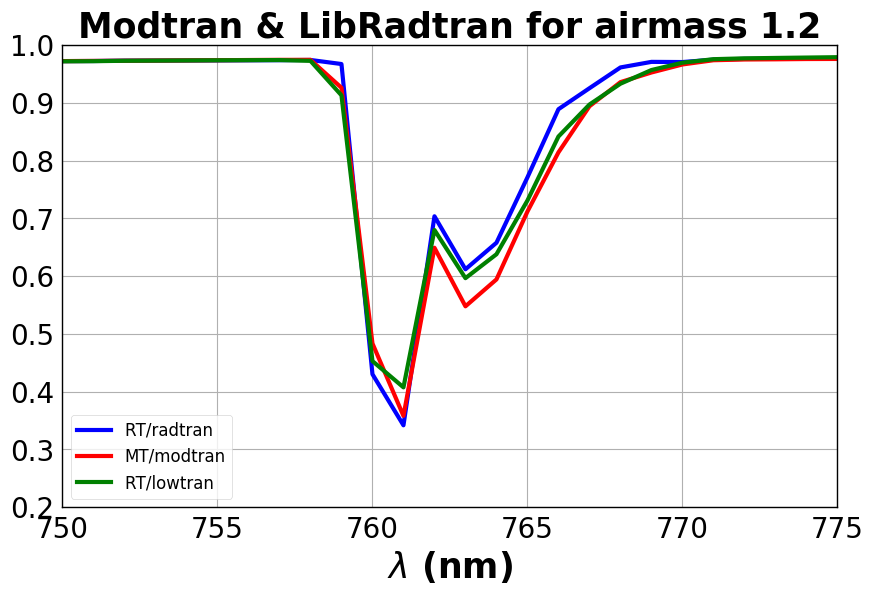

In [109]:
fig = plt.figure(figsize=(10,6))                                                               
ax = fig.add_subplot(1,1,1)  
ax.plot(all_rtdata[index_sel_airmass][:,0],all_rtdata[index_sel_airmass][:,1],"b-",lw=3,label="RT/radtran")
ax.plot(all_mtdata[index_sel_airmass][:,0],all_mtdata[index_sel_airmass][:,1],"r-",lw=3,label="MT/modtran")
ax.plot(all_ltdata[index_sel_airmass][:,0],all_ltdata[index_sel_airmass][:,1],"g-",lw=3,label="RT/lowtran")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
title='Modtran & LibRadtran for airmass {:2.1f}'.format(sel_airmass)
ax.grid(True)
ax.legend()
ax.set_title(title,fontsize=25,fontweight='bold')
ax.set_xlabel("$\lambda$ (nm)",fontsize=25,fontweight='bold')
ax.set_xlim(750.,775.)
ax.set_ylim(0.2,1.)

# Ratio

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(600.0, 800.0)

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


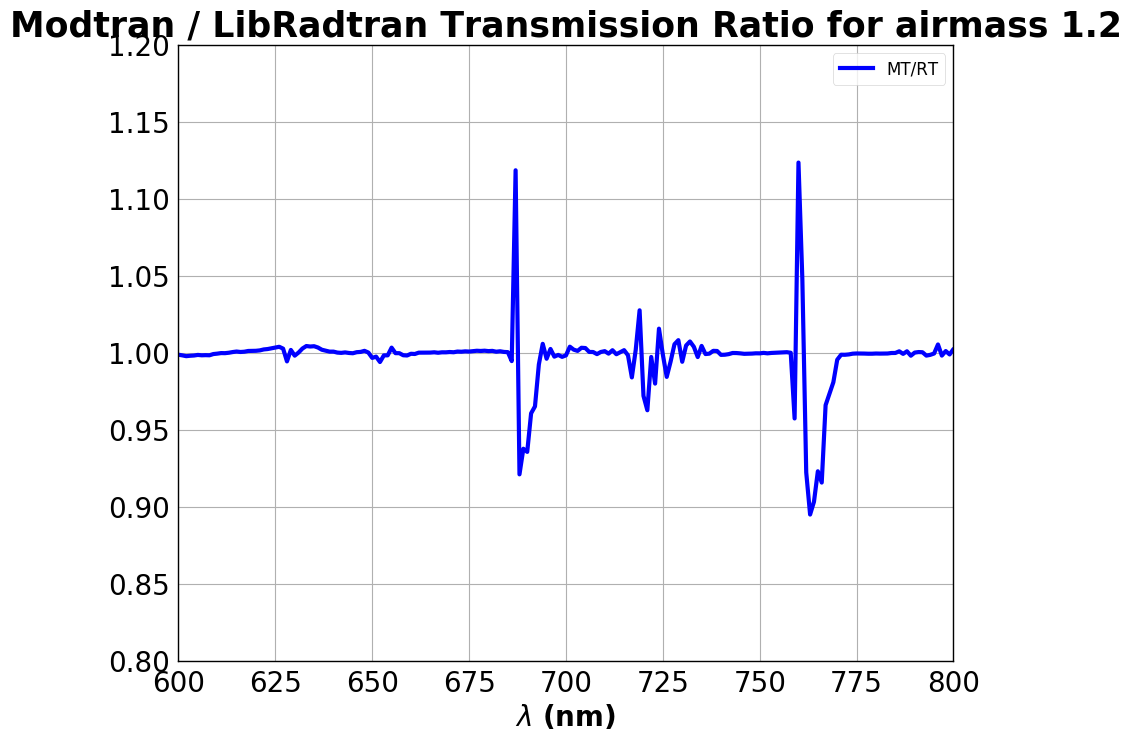

In [110]:
title='Modtran / LibRadtran Transmission Ratio for airmass {:2.1f}'.format(sel_airmass)

fig = plt.figure(figsize=(10,8))                                                               
ax = fig.add_subplot(1,1,1)  

X1=all_rtdata[index_sel_airmass][:,0]
Y1=all_rtdata[index_sel_airmass][:,1]

X2=all_mtdata[index_sel_airmass][:,0]
Y2=all_mtdata[index_sel_airmass][:,1]

func1=interp1d(X1,Y1,kind='linear') 
func2=interp1d(X2,Y2,kind='linear') 

Ratio=func2(WL)/func1(WL)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')

ax.plot(WL,Ratio,"b-",lw=3,label="MT/RT")
ax.grid(True)
ax.legend()
ax.set_title(title,fontsize=25,fontweight='bold')
ax.set_xlabel("$\lambda$ (nm)",fontsize=20,fontweight='bold')
ax.set_ylim(.8,1.2)
ax.set_xlim(600.,800.)

# Work with many airmasses

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


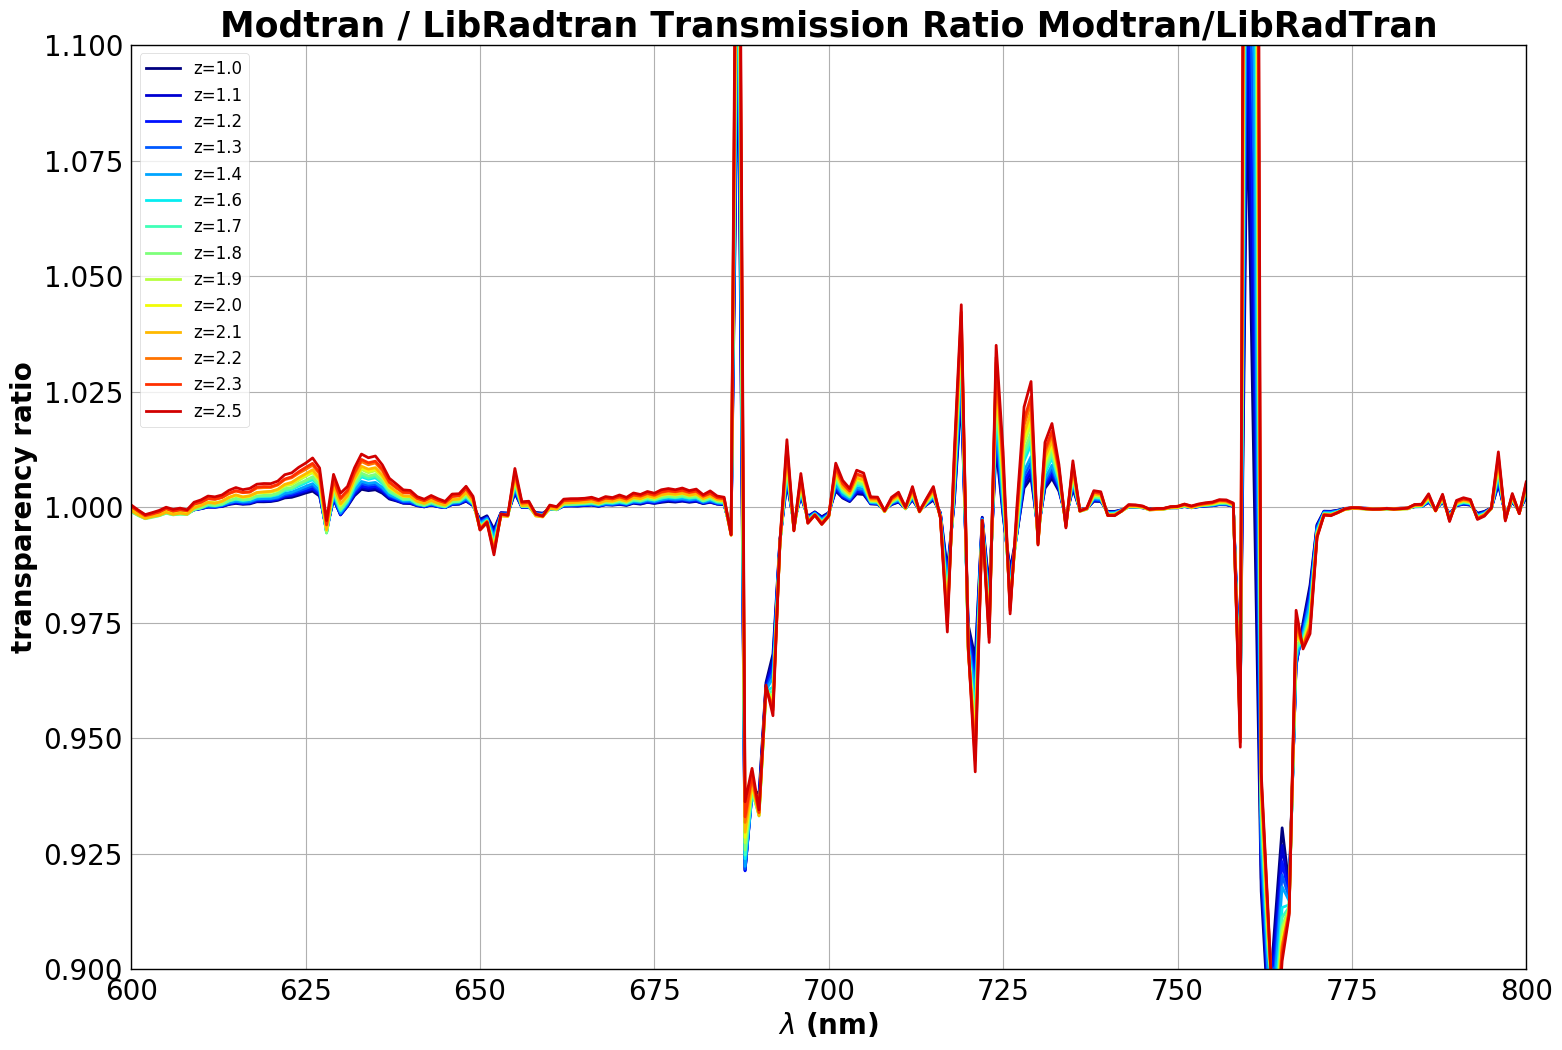

In [111]:

fig = plt.figure(figsize=(18,12))                                                               
ax = fig.add_subplot(1,1,1)  

title='Modtran / LibRadtran Transmission Ratio Modtran/LibRadTran'

for idx in np.arange(NBFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="z={:2.1f}".format(all_airmasses[idx])
    
    X1=all_rtdata[idx][:,0]
    Y1=all_rtdata[idx][:,1]

    X2=all_mtdata[idx][:,0]
    Y2=all_mtdata[idx][:,1]

    func1=interp1d(X1,Y1,kind='linear') 
    func2=interp1d(X2,Y2,kind='linear') 

    Ratio=func2(WL)/func1(WL)
    ax.plot(WL,Ratio,"-",color=colorVal,lw=2,label=thelabel)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    #tick.label.set_rotation('vertical')
ax.grid(True)
ax.set_title(title,fontsize=25,fontweight='bold')
ax.set_xlabel("$\lambda$ (nm)",fontweight='bold',fontsize=20)
ax.set_ylim(.8,1.2)
ax.set_ylabel("transparency ratio",fontweight='bold',fontsize=20)
ax.legend(loc='upper left')
ax.set_ylim(.9,1.1)
#plt.xlim(200.,1100.)
ax.set_xlim(600.,800.)
fig.savefig("mtrtratio.png")